[![Fixel Algorithms](https://i.imgur.com/AqKHVZ0.png)](https://fixelalgorithms.gitlab.io/)

# Hierarchical Clustering

This notebook focuses on _Agglomerative Clustering_ (Bottom Up).

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 1.0.000 | 13/04/2024 | Royi Avital | First version                                                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/AIProgram/2024_02/0060ClusteringHierarchical.ipynb)

In [1]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.base import BaseEstimator, ClusterMixin

# Miscellaneous
import math
import os
from platform import python_version
import random
import timeit

# Typing
from typing import Callable, Dict, List, Optional, Self, Set, Tuple, Union

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import Image
from IPython.display import display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout, SelectionSlider
from ipywidgets import interact

## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

Code Notations:

```python
someVar    = 2; #<! Notation for a variable
vVector    = np.random.rand(4) #<! Notation for 1D array
mMatrix    = np.random.rand(4, 3) #<! Notation for 2D array
tTensor    = np.random.rand(4, 3, 2, 3) #<! Notation for nD array (Tensor)
tuTuple    = (1, 2, 3) #<! Notation for a tuple
lList      = [1, 2, 3] #<! Notation for a list
dDict      = {1: 3, 2: 2, 3: 1} #<! Notation for a dictionary
oObj       = MyClass() #<! Notation for an object
dfData     = pd.DataFrame() #<! Notation for a data frame
dsData     = pd.Series() #<! Notation for a series
hObj       = plt.Axes() #<! Notation for an object / handler / function handler
```

### Code Exercise

 - Single line fill

 ```python
 vallToFill = ???
 ```

 - Multi Line to Fill (At least one)

 ```python
 # You need to start writing
 ????
 ```

 - Section to Fill

```python
#===========================Fill This===========================#
# 1. Explanation about what to do.
# !! Remarks to follow / take under consideration.
mX = ???

???
#===============================================================#
```

In [2]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# Matplotlib default color palette
lMatPltLibclr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())


In [3]:
# Constants

FIG_SIZE_DEF    = (8, 8)
ELM_SIZE_DEF    = 50
CLASS_COLOR     = ('b', 'r')
EDGE_COLOR      = 'k'
MARKER_SIZE_DEF = 10
LINE_WIDTH_DEF  = 2


In [4]:
# Courses Packages
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
from utils.DataVisualization import PlotDendrogram


In [5]:
# General Auxiliary Functions


## Clustering by Agglomerative (Bottom Up) Policy

In this note book we'll use the Agglomerative method for clustering.  
We'll use the SciPy `hierarchy` module to create a SciKit Learn compatible clustering class.

* <font color='brown'>(**#**)</font> SciKit Learn has a class for _agglomerative clustering_: [`AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html). Which is basically based on SciPy.
* <font color='brown'>(**#**)</font> The "magic" in those method is the definition of the relation between samples and sub sets of samples.

In [6]:
# Parameters

# Data Generation
csvFileName = r'https://github.com/FixelAlgorithmsTeam/FixelCourses/raw/master/DataSets/ShoppingData.csv'

# Model
linkageMethod   = 'ward' 
thrLvl          = 200
clusterCriteria = 'distance'


## Generate / Load Data

The data is based on the Shopping Data `csv` file.

* <font color='brown'>(**#**)</font> The data is known as `Mall_Customers.csv`. See [Machine Learning with Python - Datasets](https://github.com/tirthajyoti/Machine-Learning-with-Python/tree/master/Datasets).
* <font color='brown'>(**#**)</font> Available at [Kaggle - `Mall_Customers`](https://www.kaggle.com/datasets/akram24/mall-customers).


In [7]:
# Load Data

dfData = pd.read_csv(csvFileName)

print(f'The features data shape: {dfData.shape}')

The features data shape: (200, 5)


In [8]:
# The Data Frame

dfData.head(10)

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


In [9]:
# Rename the Genre Column
dfData = dfData.rename(columns = {'Genre': 'Sex'})
dfData

,CustomerID,Sex,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


### Plot Data

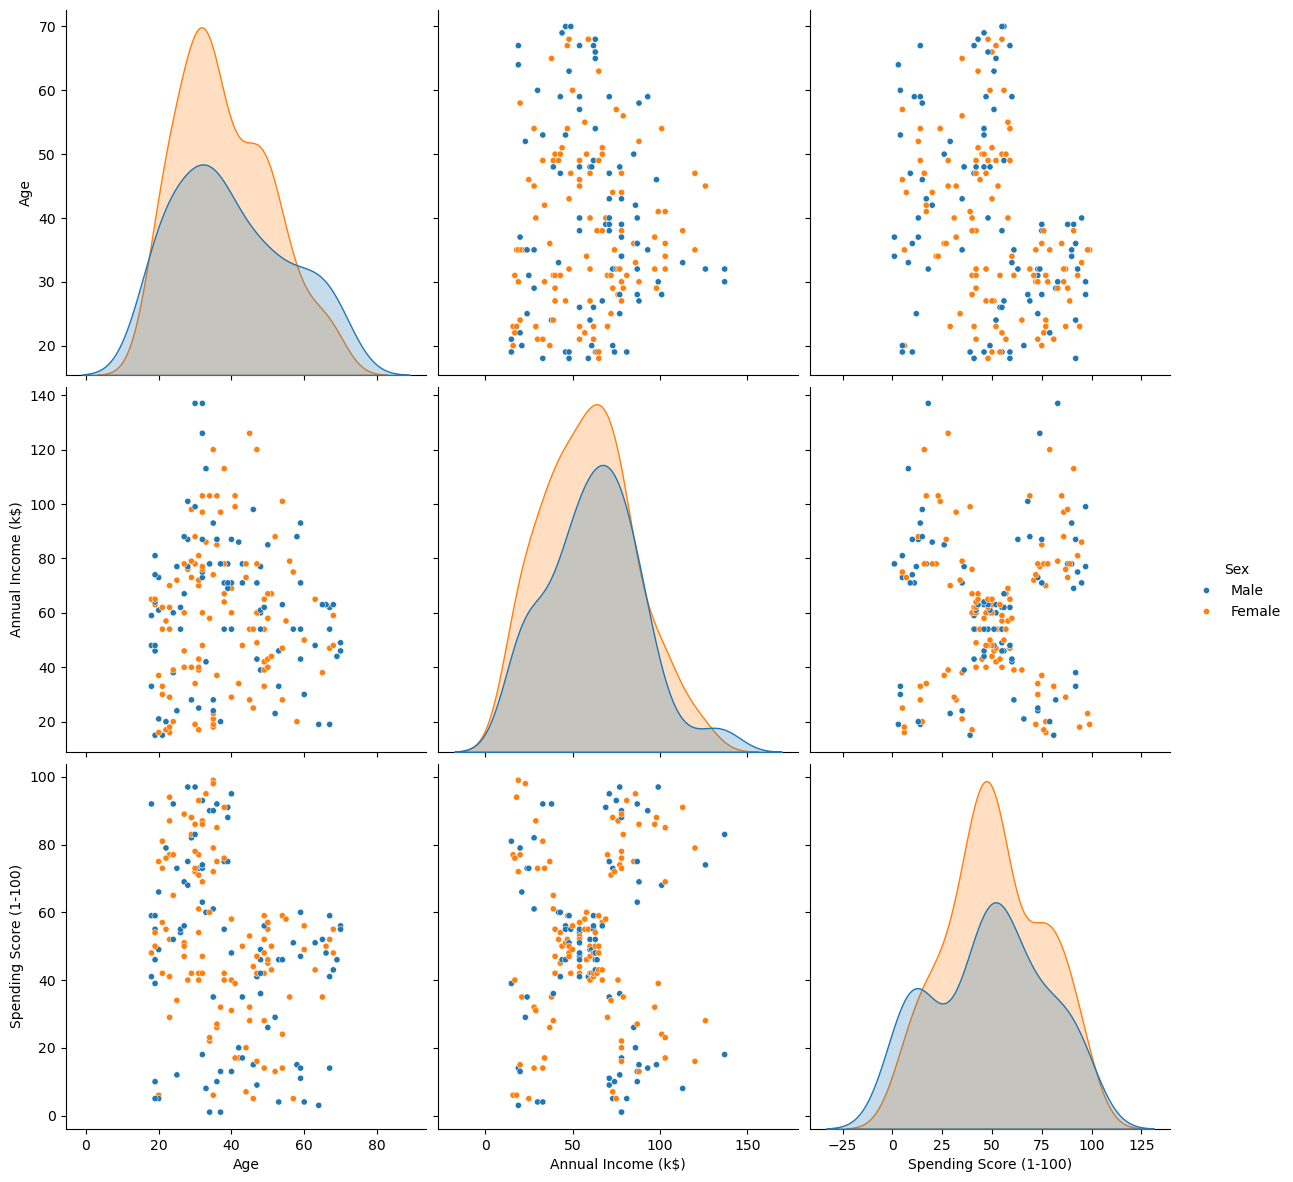

In [10]:
# Plot the Data
# Pair Plot of the data (Excluding ID)

sns.pairplot(dfData, vars = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], hue = 'Sex', height = 4, plot_kws = {'s': 20})
plt.show()

## Pre Process Data

In [11]:
# Remove ID data
dfX = dfData.drop(columns = ['CustomerID'], inplace = False)
dfX['Sex'] = dfX['Sex'].map({'Female': 0, 'Male': 1}) #<! Convert the 'Sex' column into {0, 1} values
dfX

,Sex,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40
...,...,...,...,...
195,0,35,120,79
196,0,45,126,28
197,1,32,126,74
198,1,32,137,18


## Cluster Data by Hierarchical Agglomerative (Bottom Up) Clustering Method

The algorithm works as following:

1. Set ${\color{magenta}\mathcal{C}}$, the set of all clusters: 

$$
{\color{magenta}\mathcal{C}}=\left\{{\color{green} \left\{ \boldsymbol{x}_{1}\right\}} ,{\color{green}\left\{ \boldsymbol{x}_{2}\right\}} ,\dots,{\color{green}\left\{ \boldsymbol{x}_{N}\right\}} \right\} 
$$

2. While $\left| {\color{magenta}\mathcal{C}} \right| > 1$:
   - Set ${\color{green}\mathcal{C}_{i^{\star}}},{\color{green}\mathcal{C}_{j^{\star}}}\leftarrow\arg\min_{{\color{green}\mathcal{C}_{i}},{\color{green}\mathcal{C}_{j}}\in{\color{magenta}\mathcal{C}}}d_{\mathcal{C}}\left({\color{green}\mathcal{C}_{i}},{\color{green}\mathcal{C}_{j}}\right)$.
   - Set ${\color{green}\widetilde{\mathcal{C}}}\leftarrow{\color{green}\mathcal{C}_{i^{\star}}}\cup{\color{green}\mathcal{C}_{j^{\star}}}$.
   - Set ${\color{magenta}\mathcal{C}}\leftarrow{\color{magenta}\mathcal{C}}\backslash\left\{ {\color{green}\mathcal{C}_{i^{\star}}},{\color{green}\mathcal{C}_{j^{\star}}}\right\} $.
   - Set ${\color{magenta}\mathcal{C}}\leftarrow{\color{magenta}\mathcal{C}}\cup{\color{green}\widetilde{C}}$.

The _Hyper Parameters_ of the model are:

1. The clusters dissimilarity function.
2. The clustering threshold.

* <font color='brown'>(**#**)</font> SciKit Learn has a class for _agglomerative clustering_: [`AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html). Which is basically based on SciPy.


In [12]:
# Implement the Hierarchical Agglomerative clustering as an Estimator

class HierarchicalAgglomerativeCluster(ClusterMixin, BaseEstimator):
    def __init__(self, linkageMethod: str, thrLvl: Union[int, float], clusterCriteria: str) -> None:
        self.linkageMethod      = linkageMethod
        self.thrLvl             = thrLvl
        self.clusterCriteria    = clusterCriteria

        pass        
    
    def fit(self, mX: Union[np.ndarray, pd.DataFrame], vY: Union[np.ndarray, pd.Series, None] = None) -> Self:

        numSamples  = mX.shape[0]
        featuresDim = mX.shape[1]

        mLinkage = sp.cluster.hierarchy.linkage(mX, method = self.linkageMethod)
        vL       = sp.cluster.hierarchy.fcluster(mLinkage, self.thrLvl, criterion = self.clusterCriteria)

        self.mLinkage           = mLinkage
        self.labels_            = vL
        self.n_features_in      = featuresDim

        return self
    
    def transform(self, mX: Union[np.ndarray, pd.DataFrame]) -> np.ndarray:

        return sp.hierarchy.linkage(mX, method = self.linkageMethod)
    
    def predict(self, mX: Union[np.ndarray, pd.DataFrame]) -> np.ndarray:

        vL = sp.cluster.hierarchy.fcluster(self.mLinkage, self.thrLvl, criterion = self.clusterCriteria)

        return vL


* <font color='red'>(**?**)</font> In the context of a new data, what's the limitation of this method?

In [13]:
# Plotting Wrapper
hPlotDendrogram = lambda linkageMethod, thrLvl: PlotDendrogram(dfX, linkageMethod, 200, thrLvl, figSize = (8, 8))

In [14]:
# Interactive Visualization

# TODO: Add Criteria for `fcluster`
linkageMethodDropdown = Dropdown(description = 'Linakage Method', options = [('Single', 'single'), ('Complete', 'complete'), ('Average', 'average'), ('Weighted', 'weighted'), ('Centroid', 'centroid'), ('Median', 'median'), ('Ward', 'ward')], value = 'ward')
# criteriaMethodDropdown = Dropdown(description = 'Linakage Method', options = [('Single', 'single'), ('Complete', 'complete'), ('Average', 'average'), ('Weighted', 'weighted'), ('Centroid', 'centroid'), ('Median', 'median'), ('Ward', 'ward')], value = 'ward')
thrLvlSlider = IntSlider(min = 1, max = 1000, step = 1, value = 100, layout = Layout(width = '30%'))
interact(hPlotDendrogram, linkageMethod = linkageMethodDropdown, thrLvl = thrLvlSlider)

plt.show()

## Clustering as Feature

We can visualize the effect on the data by treating the clustering labels as a feature.

In [ ]:
# Build and Train the Model
oAggCluster = HierarchicalAgglomerativeCluster(linkageMethod = linkageMethod, thrLvl = thrLvl, clusterCriteria = clusterCriteria)
oAggCluster = oAggCluster.fit(dfX)

In [ ]:
# Add the Cluster ID as a Feature
dfXX            = dfX.copy()
dfXX['Label']   = oAggCluster.labels_

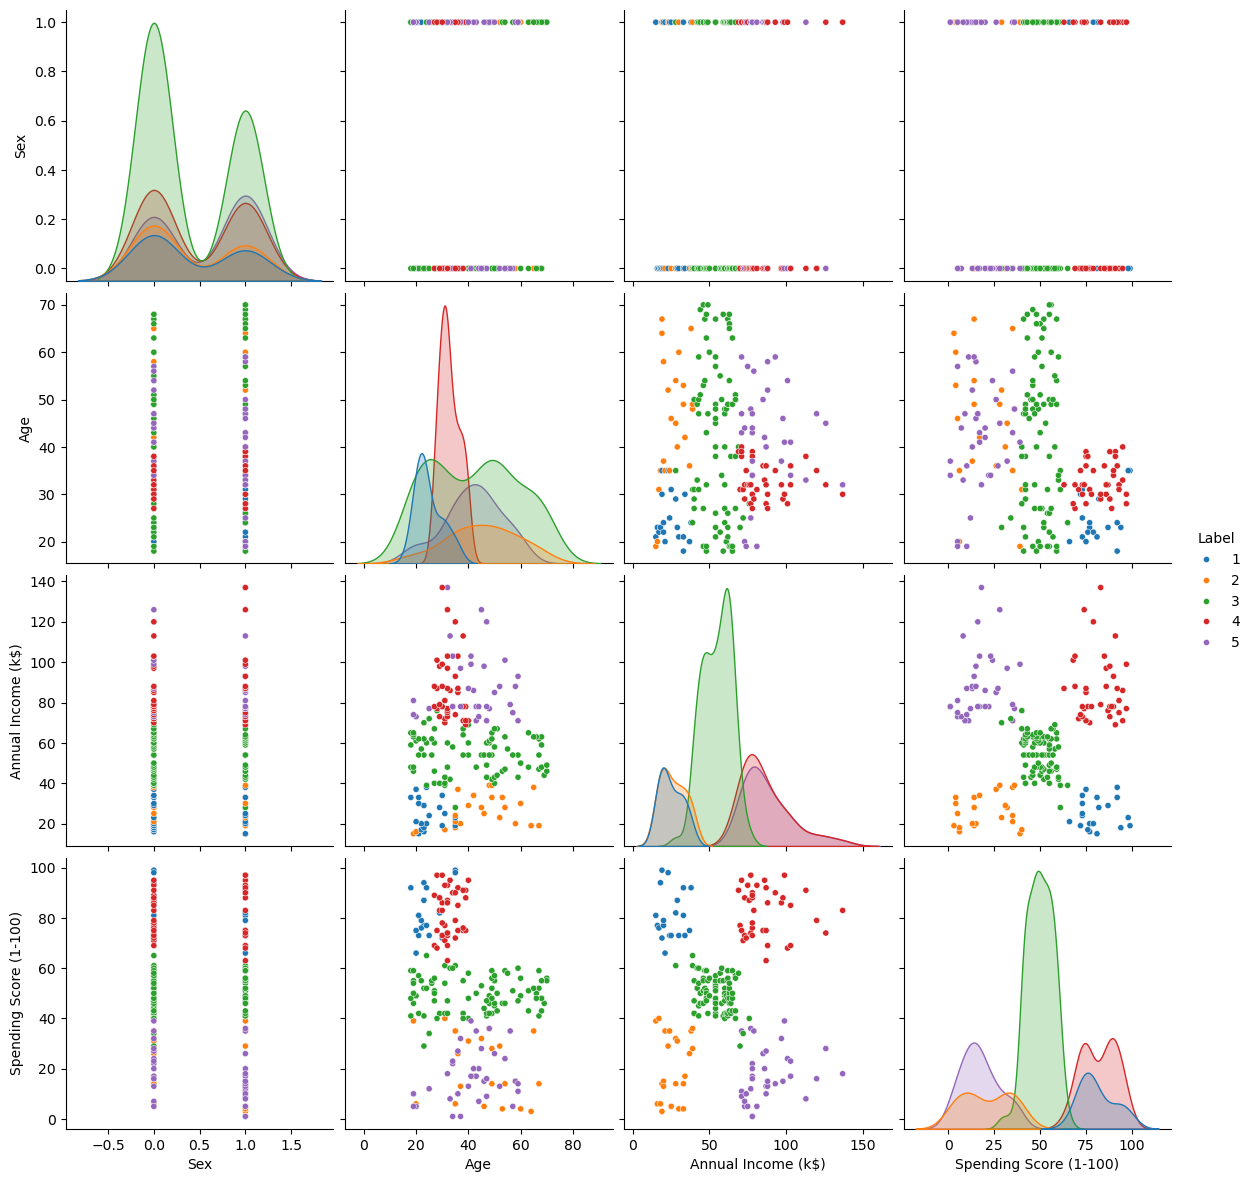

In [ ]:
# Feature Analysis
sns.pairplot(dfXX, hue = 'Label', palette = sns.color_palette()[:oAggCluster.labels_.max()], height = 3, plot_kws = {'s': 20})
plt.show()